# Modélisation Prédictive pour SmartCare Analytics

## Objectif
Ce notebook a pour but de développer et comparer différents modèles de prédiction pour anticiper :
1. **Le nombre d'admissions aux urgences** (par heure)
2. **L'occupation des lits** (nombre de lits occupés)
3. **La consommation d'EPI** (Équipements de Protection Individuelle)

## Approche méthodologique
Nous testons trois approches de modélisation :
- **Prophet** : Modèle de séries temporelles développé par Meta, excellent pour capturer les saisonnalités
- **XGBoost** : Algorithme de gradient boosting, performant avec des features engineerées
- **Modèle Hybride** : Fusion Prophet + XGBoost où XGBoost corrige les erreurs de Prophet

> **Note importante** : Pour les prédictions des lits occupés et de la consommation d'EPI, nous avons choisi d'utiliser uniquement Prophet. Les tests ont montré peu d'amélioration avec XGBoost ou l'approche hybride, et Prophet offre une meilleure simplicité d'implémentation et d'interprétation pour ces métriques.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib

## Importation des bibliothèques

Nous utilisons :
- **pandas** : Manipulation des données
- **matplotlib/seaborn** : Visualisation
- **Prophet** : Modèle de séries temporelles
- **XGBoost** : Gradient boosting
- **scikit-learn** : Métriques d'évaluation (MAE, RMSE)
- **joblib** : Sauvegarde des modèles

In [2]:
df = pd.read_csv("hospital_synth.csv", sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315648 entries, 0 to 315647
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   timestamp_admission   315648 non-null  object 
 1   Service               315648 non-null  object 
 2   Nombre_Admissions     315648 non-null  int64  
 3   motif_admission       315648 non-null  object 
 4   gravite               315648 non-null  int64  
 5   duree_sejour_estimee  315648 non-null  float64
 6   type_lit_requis       315648 non-null  object 
 7   facteur_externe       315648 non-null  object 
 8   Lits_Occupes          315648 non-null  int64  
 9   Lits_Disponibles      315648 non-null  int64  
 10  Personnel_Present     315648 non-null  int64  
 11  Stock_EPI             315648 non-null  int64  
 12  EPI_Consommation      315648 non-null  int64  
 13  Rupture_Stock         315648 non-null  int64  
 14  Indicateur_Epidemie   315648 non-null  int64  
 15  

## Chargement des données

Le dataset `hospital_synth.csv` contient des données horaires simulées sur 5 ans incluant :
- Nombre d'admissions
- Occupation des lits
- Consommation d'EPI
- Indicateurs contextuels (épidémie, canicule, grève)

---
# Partie 1 : Prédiction du Nombre d'Admissions

Cette section compare trois approches pour prédire le nombre d'admissions aux urgences :
1. Prophet seul
2. XGBoost seul
3. Modèle hybride (Prophet + XGBoost)

## 1.1 Préparation des données pour Prophet

**Étapes de préparation :**
1. **Typage** : Conversion du timestamp en datetime
2. **Resampling horaire** : Agrégation des données par heure
3. **Renommage** : Prophet exige les colonnes `ds` (date) et `y` (cible)
4. **Split temporel** : Données avant 2025 pour l'entraînement, après pour le test

In [3]:
# 1. Typage
df['timestamp_admission'] = pd.to_datetime(df['timestamp_admission'])

# 2. Segmentation
df_urgences = df.copy()

# 3. Resampling (Rythme imposé)
# On agrège par heure pour avoir une série temporelle propre.
# 'sum' pour les admissions, 'max' pour les indicateurs (s'il y a grève à 14h15, il y a grève à 14h00).
df_prepared = df_urgences.set_index('timestamp_admission').resample('h').agg({
    'Nombre_Admissions': 'sum',
    'Indicateur_Epidemie': 'max',
    'Indicateur_Canicule': 'max',
    'Indicateur_Greve': 'max'
}).reset_index()

# 4. Traduction pour Prophet
df_prophet = df_prepared.rename(columns={
    'timestamp_admission': 'ds', # Le temps
    'Nombre_Admissions': 'y'     # Le signal à prédire
})

# 5. La Coupure Temporelle (Train vs Test)
cutoff_date = '2025-01-01'
train = df_prophet[df_prophet['ds'] < cutoff_date]
test = df_prophet[df_prophet['ds'] >= cutoff_date]

print(f"Mémoire d'entraînement (Train): {train.shape[0]} heures")
print(f"Futur à prédire (Test): {test.shape[0]} heures")
print(train.head())

Mémoire d'entraînement (Train): 43848 heures
Futur à prédire (Test): 8760 heures
                   ds   y  Indicateur_Epidemie  Indicateur_Canicule  \
0 2020-01-01 00:00:00  13                    0                    0   
1 2020-01-01 01:00:00  10                    0                    0   
2 2020-01-01 02:00:00  18                    0                    0   
3 2020-01-01 03:00:00  16                    0                    0   
4 2020-01-01 04:00:00  18                    0                    0   

   Indicateur_Greve  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


## 1.2 Configuration et entraînement de Prophet

**Paramètres clés :**
- **changepoint_prior_scale=0.1** : Permet à la tendance de réagir plus rapidement aux changements
- **seasonality_prior_scale=10.0** : Autorise des fluctuations saisonnières de grande amplitude
- **Saisonnalités personnalisées** :
  - Journalière (fourier_order=20) : Capture les pics fins dans la journée
  - Hebdomadaire (fourier_order=10) : Distingue les jours de semaine du week-end
  - Annuelle : Capture les variations saisonnières (grippe en hiver, etc.)
- **Régresseurs externes** : Indicateurs d'épidémie, canicule et grève

In [4]:
m = Prophet(
    # On coupe la gestion auto pour la gérer manuellement avec plus de finesse
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,

    # LEVIER 1 : Flexibilité de la tendance
    # Permet au modèle de changer de direction plus vite (Trend plus réactif)
    changepoint_prior_scale=0.1,

    # LEVIER 2 : Force de la saisonnalité
    # Autorise des fluctuations saisonnières de grande amplitude
    seasonality_prior_scale=10.0
)

# LEVIER 3 : Haute Résolution Temporelle (Fourier Order)
# daily period=1. fourier_order=20 permet de capter des pics très brefs dans la journée.
m.add_seasonality(name='daily', period=1, fourier_order=20)

# On rajoute la semaine aussi avec plus de détails (le week-end est spécifique)
m.add_seasonality(name='weekly', period=7, fourier_order=10)

m.add_regressor('Indicateur_Epidemie')
m.add_regressor('Indicateur_Canicule')
m.add_regressor('Indicateur_Greve')

# On ne lui donne que le passé (Train).
print("Début de l'entraînement...")
m.fit(train)

Début de l'entraînement...


10:40:05 - cmdstanpy - INFO - Chain [1] start processing
10:40:15 - cmdstanpy - INFO - Chain [1] done processing


## 1.3 Évaluation de Prophet

**Métriques utilisées :**
- **MAE (Mean Absolute Error)** : Erreur moyenne en valeur absolue
- **RMSE (Root Mean Squared Error)** : Pénalise davantage les grandes erreurs

Les visualisations comparent les prédictions à la réalité sur différentes fenêtres temporelles.

--- Performance de Prophet ---
MAE: 3.86
RMSE: 4.88


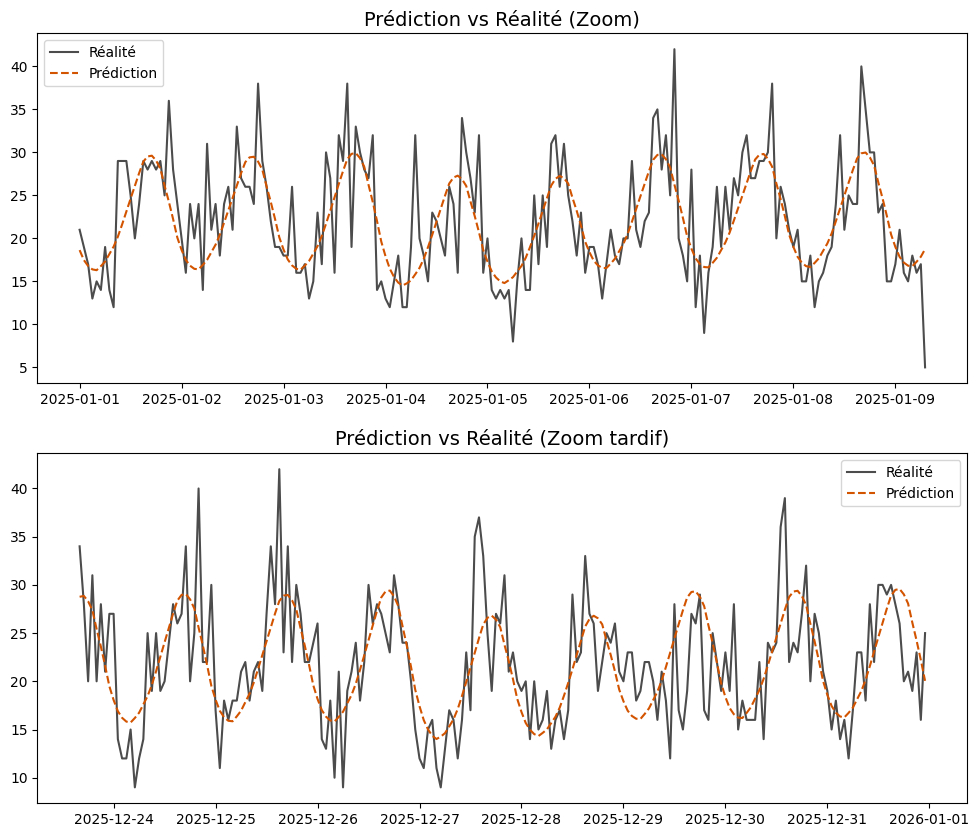

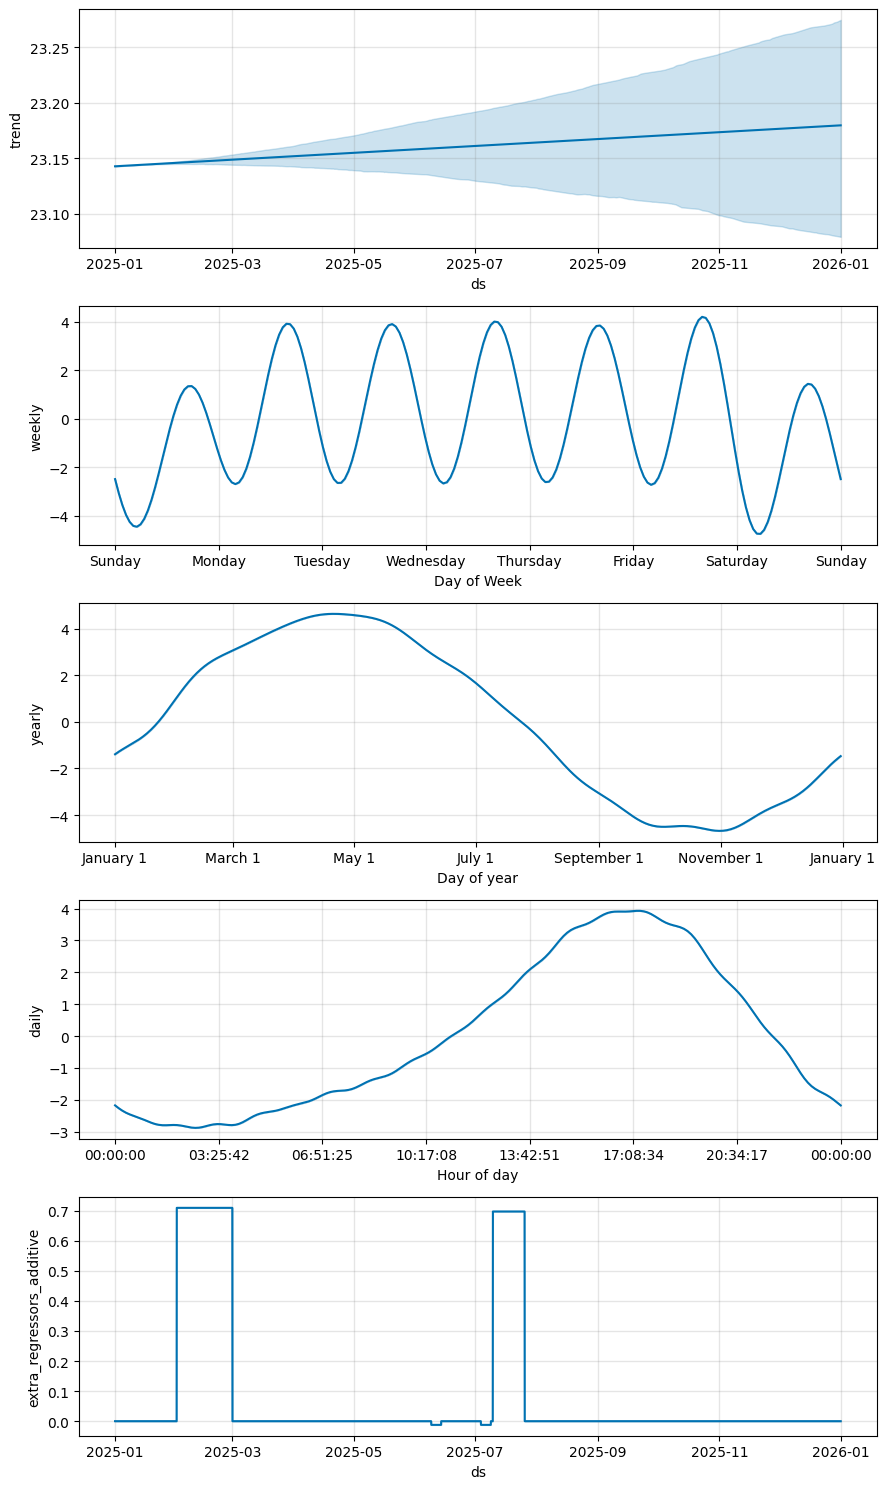

In [5]:
# On demande au modèle de prédire sur le dataset de Test.
# Note : Prophet a besoin des régresseurs futurs pour prédire le futur !
forecast = m.predict(test)

# On compare 'yhat' (la prédiction) avec 'y' (la vérité du testset)
y_true = test['y'].values
y_pred = forecast['yhat'].values

# Métriques de performance
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"--- Performance de Prophet ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualisation
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
# On zoome sur une fenêtre courte (ex: 200 heures) pour voir les détails
limit = 200
axs[0].plot(test['ds'].iloc[:limit], y_true[:limit], label='Réalité', color='black', alpha=0.7)
axs[0].plot(test['ds'].iloc[:limit], y_pred[:limit], label='Prédiction', color='#D35400', linestyle='--')
axs[0].set_title('Prédiction vs Réalité (Zoom)', fontsize=14)
axs[0].legend()
# On zoome sur une fenêtre courte mais plus tard dans le temps (à la fin du test)
axs[1].plot(test['ds'].iloc[-limit:], y_true[-limit:], label='Réalité', color='black', alpha=0.7)
axs[1].plot(test['ds'].iloc[-limit:], y_pred[-limit:], label='Prédiction', color='#D35400', linestyle='--')
axs[1].set_title('Prédiction vs Réalité (Zoom tardif)', fontsize=14)
axs[1].legend()

plt.show()

# Bonus : Voir les composants (L'anatomie de la décision)
fig2 = m.plot_components(forecast)

## 1.4 Vue d'ensemble sur l'année

Visualisation dézoomée pour observer le comportement du modèle sur l'ensemble de la période de test.

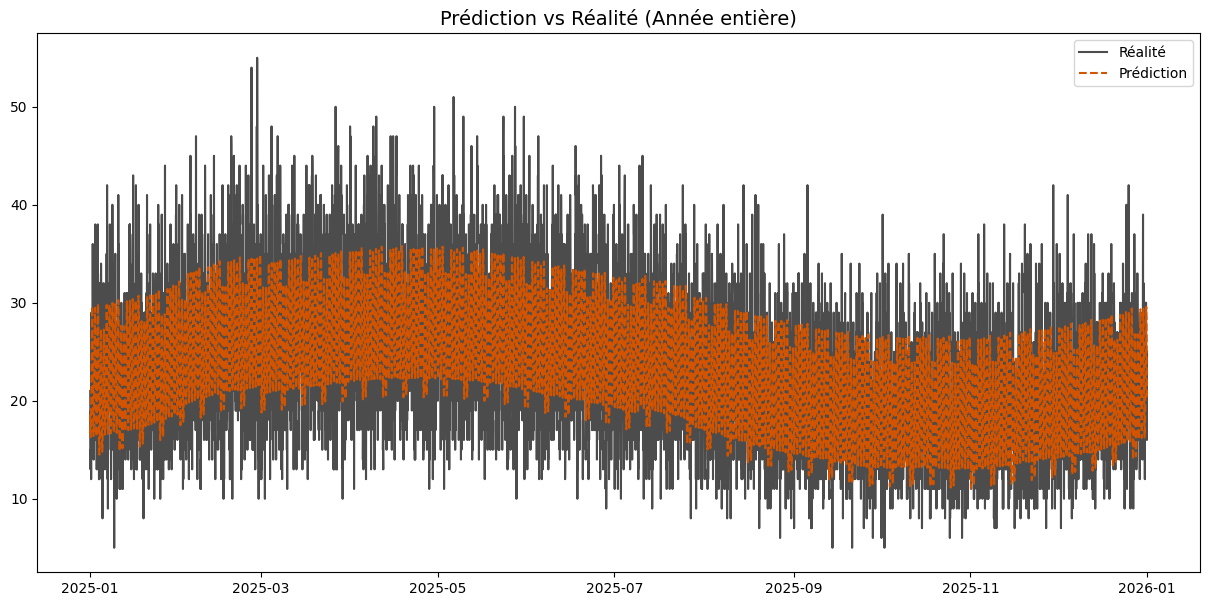

In [6]:
# plot pour montrer comment le modèle gère l'année entière (on dézoome)
plt.figure(figsize=(15, 7))
plt.plot(test['ds'], y_true, label='Réalité', color='black', alpha=0.7)
plt.plot(test['ds'], y_pred, label='Prédiction', color='#D35400', linestyle='--')
plt.title('Prédiction vs Réalité (Année entière)', fontsize=14)
plt.legend()
plt.show()

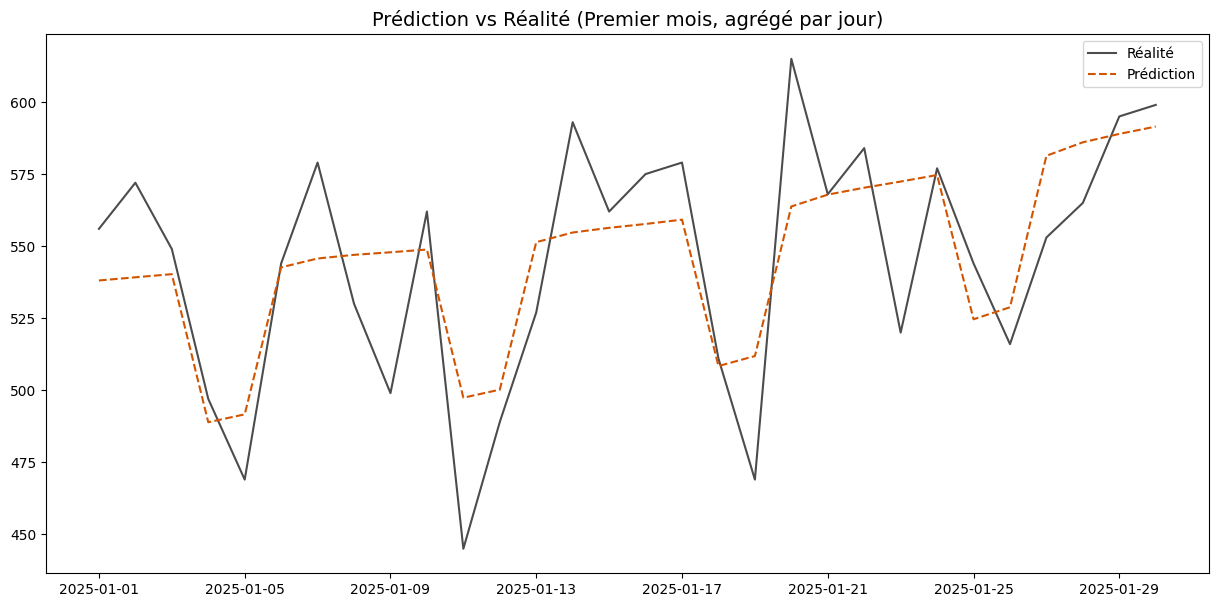

In [7]:
# zoom sur le premier mois, mais on agrège les données par jour
plt.figure(figsize=(15, 7))
test_daily = test.set_index('ds').resample('d').sum().reset_index()
y_true_daily = test_daily['y'].values
y_pred_daily = forecast.set_index('ds').resample('d').sum().reset_index()['yhat'].values
plt.plot(test_daily['ds'][:30], y_true_daily[:30], label='Réalité', color='black', alpha=0.7)
plt.plot(test_daily['ds'][:30], y_pred_daily[:30], label='Prédiction', color='#D35400', linestyle='--')
plt.title('Prédiction vs Réalité (Premier mois, agrégé par jour)', fontsize=14)
plt.legend()
plt.show()


## 1.5 Sauvegarde du modèle Prophet

Le modèle est sauvegardé au format `.pkl` pour une utilisation ultérieure en production.

In [8]:
# save the prophet model
joblib.dump(m, 'admissions_prophet_model.pkl')

['admissions_prophet_model.pkl']

---
## 1.6 Approche XGBoost : Feature Engineering

XGBoost nécessite un **feature engineering** plus poussé que Prophet :

**Features temporelles :**
- Heure, jour de la semaine, mois
- **Encodage cyclique** : Transforme les variables temporelles en sinus/cosinus pour que le modèle comprenne que 23h est proche de 0h

**Features de mémoire (Lags) :**
- `lag_1h`, `lag_2h` : Admissions il y a 1 et 2 heures
- `lag_24h` : Même heure hier (rythme circadien)
- `lag_168h` : Même heure la semaine dernière (rythme hebdomadaire)

**Statistiques glissantes :**
- `rolling_mean_3h` : Moyenne mobile sur 3 heures

In [9]:
# 1. Chargement
df_urgences = df.copy()

# Resampling Horaire
df_prepared = df_urgences.set_index('timestamp_admission').resample('h').agg({
    'Nombre_Admissions': 'sum',
    'Indicateur_Epidemie': 'max',
    'Indicateur_Canicule': 'max',
    'Indicateur_Greve': 'max'
}).reset_index()

# --- 2. Feature Engineering Avancé (La clé du succès) ---

# A. Extraction basique
df_prepared['hour'] = df_prepared['timestamp_admission'].dt.hour
df_prepared['dayofweek'] = df_prepared['timestamp_admission'].dt.dayofweek
df_prepared['month'] = df_prepared['timestamp_admission'].dt.month
df_prepared['year'] = df_prepared['timestamp_admission'].dt.year

# B. Encodage Cyclique (Pour que le modèle comprenne que 23h ~ 00h)
# C'est de la géométrie temporelle.
df_prepared['hour_sin'] = np.sin(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['hour_cos'] = np.cos(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['month_sin'] = np.sin(2 * np.pi * df_prepared['month'] / 12)
df_prepared['month_cos'] = np.cos(2 * np.pi * df_prepared['month'] / 12)

# C. La Mémoire (Lags)
# "Combien de gens sont arrivés il y a une heure ? Hier à la même heure ?"
df_prepared['lag_1h'] = df_prepared['Nombre_Admissions'].shift(1)
df_prepared['lag_2h'] = df_prepared['Nombre_Admissions'].shift(2)
df_prepared['lag_24h'] = df_prepared['Nombre_Admissions'].shift(24) # Rythme circadien
df_prepared['lag_168h'] = df_prepared['Nombre_Admissions'].shift(168) # Rythme hebdo

# D. Statistiques Glissantes (Rolling Window)
# "Tendance récente sur 3 heures"
df_prepared['rolling_mean_3h'] = df_prepared['Nombre_Admissions'].shift(1).rolling(window=3).mean()

# Nettoyage des NaN créés par les lags
df_model = df_prepared.dropna()

# --- 3. Train / Test Split ---
cutoff_date = '2025-01-01'
train = df_model[df_model['timestamp_admission'] < cutoff_date]
test = df_model[df_model['timestamp_admission'] >= cutoff_date]

# Définition des features (On enlève le timestamp et la cible)
features = [
    'Indicateur_Epidemie', 'Indicateur_Canicule', 'Indicateur_Greve',
    'hour_sin', 'hour_cos', 'dayofweek', 'month_sin', 'month_cos',
    'lag_1h', 'lag_2h', 'lag_24h', 'lag_168h', 'rolling_mean_3h'
]
target = 'Nombre_Admissions'

## 1.7 Entraînement XGBoost

**Configuration du modèle :**
- **n_estimators=1000** : Nombre d'arbres dans l'ensemble
- **learning_rate=0.05** : Apprentissage progressif pour éviter le surapprentissage
- **max_depth=5** : Limite la complexité de chaque arbre
- **early_stopping_rounds=50** : Arrête l'entraînement si pas d'amélioration

In [10]:
# --- Le Modèle XGBoost ---
print("Initialisation du Booster...")
model = xgb.XGBRegressor(
    n_estimators=1000,      # Nombre d'arbres (le comité d'experts)
    learning_rate=0.05,     # Vitesse d'apprentissage (doucement mais sûrement)
    max_depth=5,            # Complexité de chaque arbre
    early_stopping_rounds=50, # Arrête si ça ne s'améliore plus
    n_jobs=-1,
    random_state=42
)

# Entraînement avec validation set pour l'early stopping
model.fit(
    train[features], train[target],
    eval_set=[(train[features], train[target]), (test[features], test[target])],
    verbose=100 # Affiche le progrès tous les 100 arbres
)

Initialisation du Booster...
[0]	validation_0-rmse:7.35109	validation_1-rmse:7.35870
[100]	validation_0-rmse:4.79771	validation_1-rmse:4.87440
[200]	validation_0-rmse:4.73072	validation_1-rmse:4.87218
[232]	validation_0-rmse:4.71439	validation_1-rmse:4.87257


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

## 1.8 Évaluation XGBoost

Comparaison des performances avec Prophet et visualisation de l'importance des features.
L'importance des features permet de comprendre quelles variables influencent le plus les prédictions.


--- Performance XGBoost ---
MAE: 3.86
RMSE: 4.87


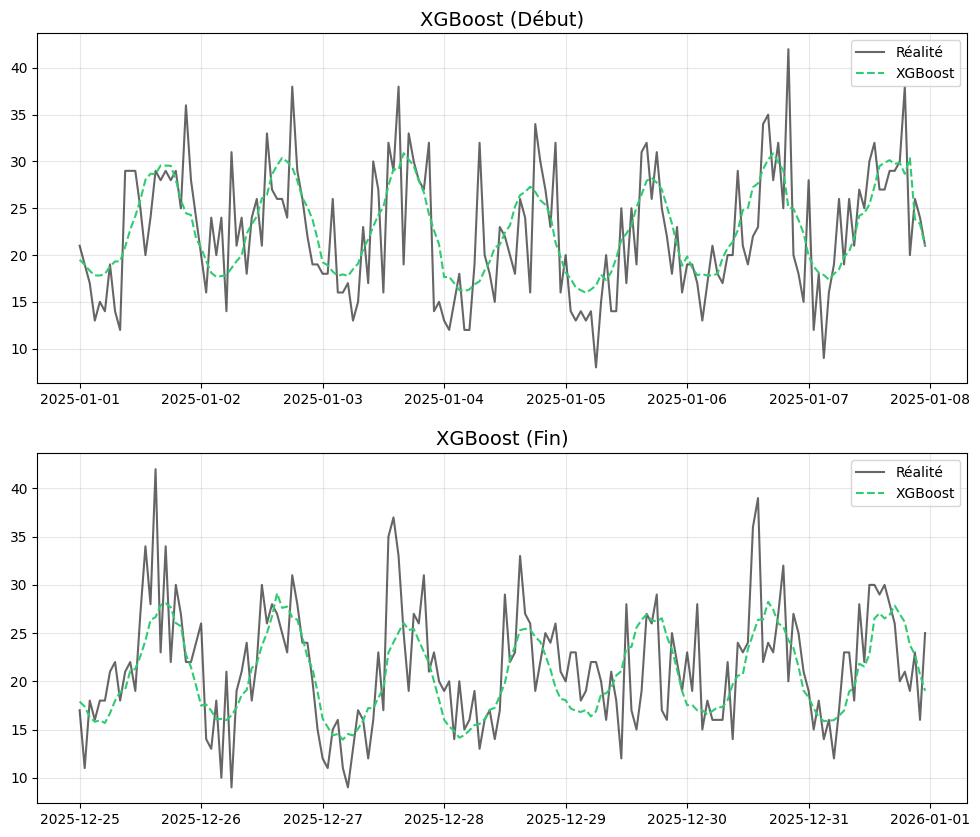

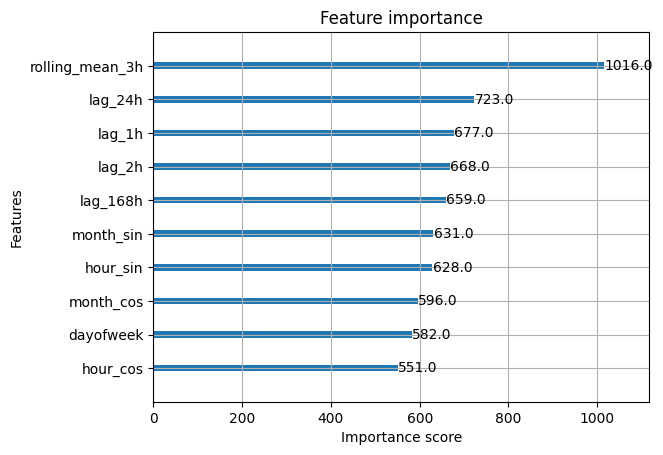

In [11]:

# --- Prédiction & Évaluation ---
predictions = model.predict(test[features])
# On empêche les prédictions négatives
predictions = np.maximum(predictions, 0)

mae = mean_absolute_error(test[target], predictions)
rmse = np.sqrt(mean_squared_error(test[target], predictions))

print(f"\n--- Performance XGBoost ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualisation Zoom, au début du test et à la fin
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
limit = 168 # Une semaine
# début
axs[0].plot(test['timestamp_admission'].iloc[:limit], test[target].iloc[:limit], label='Réalité', color='black', alpha=0.6)
axs[0].plot(test['timestamp_admission'].iloc[:limit], predictions[:limit], label='XGBoost', color='#2ECC71', linestyle='--') # Vert Matrix
axs[0].set_title('XGBoost (Début)', fontsize=14)
axs[0].legend()
axs[0].grid(True, alpha=0.3)
# fin
axs[1].plot(test['timestamp_admission'].iloc[-limit:], test[target].iloc[-limit:], label='Réalité', color='black', alpha=0.6)
axs[1].plot(test['timestamp_admission'].iloc[-limit:], predictions[-limit:], label='XGBoost', color='#2ECC71', linestyle='--') # Vert Matrix
axs[1].set_title('XGBoost (Fin)', fontsize=14)
axs[1].legend()
axs[1].grid(True, alpha=0.3)
plt.show()

# Feature Importance (Pour comprendre le cerveau de la machine)
xgb.plot_importance(model, max_num_features=10)
plt.show()

## 1.9 Vue d'ensemble XGBoost sur l'année

Visualisation complète de la période de test pour évaluer la cohérence des prédictions XGBoost.

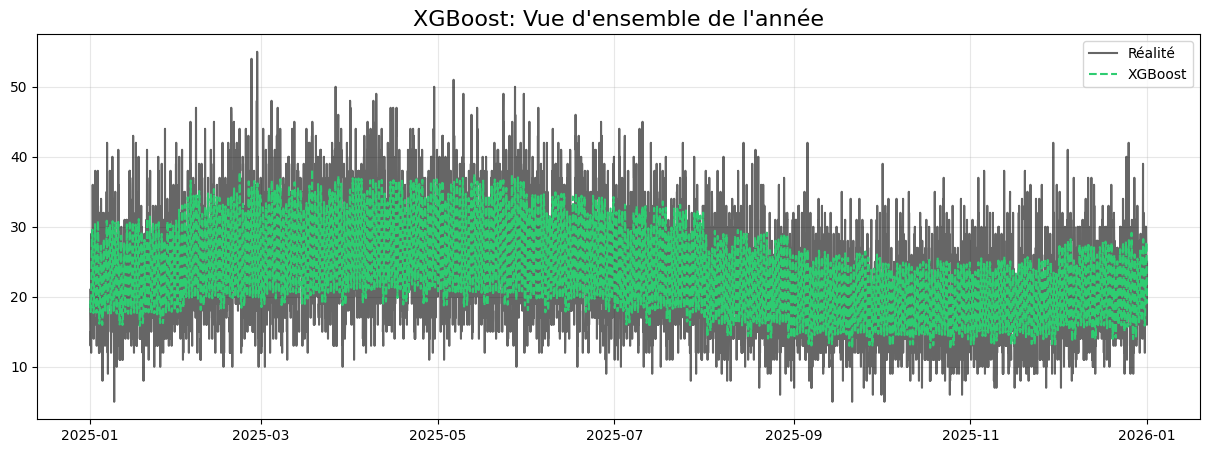

In [12]:
# plot pour montrer comment XGBoost gère l'année entière (on dézoome)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test['timestamp_admission'], test[target], label='Réalité', color='black', alpha=0.6)
ax.plot(test['timestamp_admission'], predictions, label='XGBoost', color='#2ECC71', linestyle='--') # Vert Matrix
ax.set_title("XGBoost: Vue d'ensemble de l'année", fontsize=16)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

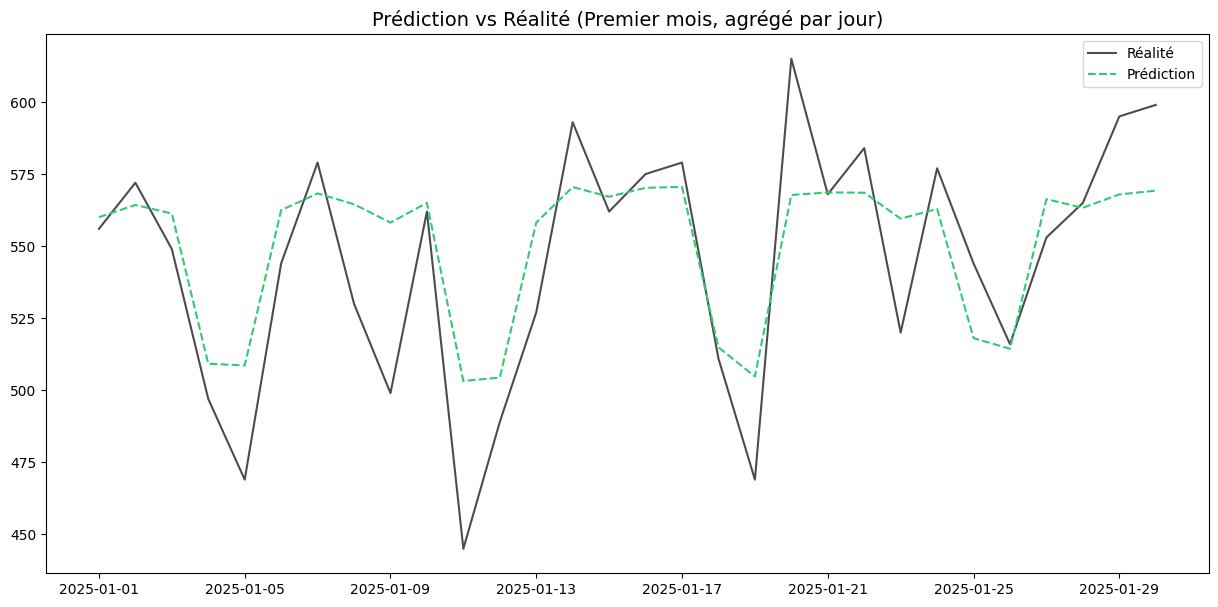

In [13]:
# zoom sur le premier mois, mais on agrège les données par jour
plt.figure(figsize=(15, 7))
test_daily = test.set_index('timestamp_admission').resample('d').sum().reset_index()
y_true_daily = test_daily['Nombre_Admissions'].values
y_pred_daily = pd.Series(predictions, index=test['timestamp_admission']).resample('d').sum().values
plt.plot(test_daily['timestamp_admission'][:30], y_true_daily[:30], label='Réalité', color='black', alpha=0.7)
plt.plot(test_daily['timestamp_admission'][:30], y_pred_daily[:30], label='Prédiction', color='#2ECC71', linestyle='--')
plt.title('Prédiction vs Réalité (Premier mois, agrégé par jour)', fontsize=14)
plt.legend()
plt.show()

---
## 1.10 Modèle Hybride : Prophet + XGBoost

**Concept :** Combiner les forces des deux approches
- **Prophet** : Capture les tendances et saisonnalités long terme
- **XGBoost** : Corrige les erreurs résiduelles avec les patterns court terme

**Méthode :**
1. Prophet prédit les admissions
2. On calcule les **résidus** (Réalité - Prédiction Prophet)
3. XGBoost apprend à prédire ces résidus
4. Prédiction finale = Prédiction Prophet + Correction XGBoost

In [14]:
# --- 1. Préparation des Données (Standard) ---
# 1. Typage
df['timestamp_admission'] = pd.to_datetime(df['timestamp_admission'])

# 2. Segmentation
df_urgences = df.copy()

# 3. Resampling (Rythme imposé)
# On agrège par heure pour avoir une série temporelle propre.
# 'sum' pour les admissions, 'max' pour les indicateurs (s'il y a grève à 14h15, il y a grève à 14h00).
df_prepared = df_urgences.set_index('timestamp_admission').resample('h').agg({
    'Nombre_Admissions': 'sum',
    'Indicateur_Epidemie': 'max',
    'Indicateur_Canicule': 'max',
    'Indicateur_Greve': 'max'
}).reset_index()

# 4. Traduction pour Prophet
df_prepared = df_prepared.rename(columns={
    'timestamp_admission': 'ds', # Le temps
    'Nombre_Admissions': 'y'     # Le signal à prédire
})

# --- 2. Feature Engineering Avancé (La clé du succès) ---

# A. Extraction basique
df_prepared['hour'] = df_prepared['ds'].dt.hour
df_prepared['dayofweek'] = df_prepared['ds'].dt.dayofweek
df_prepared['month'] = df_prepared['ds'].dt.month
df_prepared['year'] = df_prepared['ds'].dt.year

# B. Encodage Cyclique (Pour que le modèle comprenne que 23h ~ 00h)
# C'est de la géométrie temporelle.
df_prepared['hour_sin'] = np.sin(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['hour_cos'] = np.cos(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['month_sin'] = np.sin(2 * np.pi * df_prepared['month'] / 12)
df_prepared['month_cos'] = np.cos(2 * np.pi * df_prepared['month'] / 12)

# C. La Mémoire (Lags)
# "Combien de gens sont arrivés il y a une heure ? Hier à la même heure ?"
df_prepared['lag_1h'] = df_prepared['y'].shift(1)
df_prepared['lag_2h'] = df_prepared['y'].shift(2)
df_prepared['lag_24h'] = df_prepared['y'].shift(24) # Rythme circadien
df_prepared['lag_168h'] = df_prepared['y'].shift(168) # Rythme hebdo

# D. Statistiques Glissantes (Rolling Window)
# "Tendance récente sur 3 heures"
df_prepared['rolling_mean_3h'] = df_prepared['y'].shift(1).rolling(window=3).mean()

# Nettoyage des NaN créés par les lags
df_model = df_prepared.dropna()

# --- 3. Train / Test Split ---
cutoff_date = '2025-01-01'
train = df_model[df_model['ds'] < cutoff_date]
test = df_model[df_model['ds'] >= cutoff_date]

# Définition des features (On enlève le timestamp et la cible)
features = [
    'Indicateur_Epidemie', 'Indicateur_Canicule', 'Indicateur_Greve',
    'hour_sin', 'hour_cos', 'dayofweek', 'month_sin', 'month_cos',
    'lag_1h', 'lag_2h', 'lag_24h', 'lag_168h', 'rolling_mean_3h'
]
target = 'y'

## 1.11 Entraînement du Prophète (Modèle de base)

Première étape du modèle hybride : entraînement de Prophet et calcul des résidus sur le jeu d'entraînement.

In [15]:
# --- 2. ÉTAPE 1 : Le Prophète (Base Model) ---
print(">>> Entrainement de Prophet...")
m = Prophet(
    daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True,
    changepoint_prior_scale=0.1, seasonality_prior_scale=10.0
)
m.add_seasonality(name='daily', period=1, fourier_order=15)
m.add_seasonality(name='weekly', period=7, fourier_order=10)
m.add_regressor('Indicateur_Epidemie')
m.add_regressor('Indicateur_Canicule')
m.add_regressor('Indicateur_Greve')

m.fit(train)

# Prédictions de base
forecast_train = m.predict(train)
forecast_test = m.predict(test)

# --- 3. Calcul des Résidus (Ce que Prophet n'a pas compris) ---
# Résidu = Réalité - Prédiction Prophet
y_train_residuals = train['y'].values - forecast_train['yhat'].values

>>> Entrainement de Prophet...


10:40:30 - cmdstanpy - INFO - Chain [1] start processing
10:40:41 - cmdstanpy - INFO - Chain [1] done processing


## 1.12 Entraînement du Correcteur XGBoost

XGBoost est entraîné sur les **résidus** (erreurs de Prophet), pas sur les admissions directement.
Il utilise principalement les features de mémoire court terme (lags) pour affiner les prédictions.

In [16]:
# --- 4. ÉTAPE 2 : Le Correcteur (XGBoost sur les Résidus) ---
print(">>> Entrainement de XGBoost...")

# On utilise les features "court terme" pour corriger
xgb_features = [
    'lag_1h', 'lag_24h', 'rolling_mean_3h', # La mémoire immédiate
    'Indicateur_Epidemie', 'Indicateur_Greve' # Le contexte
]

xgb_corrector = xgb.XGBRegressor(
    n_estimators=500, max_depth=4, learning_rate=0.05, n_jobs=-1, random_state=42
)

# ATTENTION : On entraîne XGBoost à prédire l'ERREUR (residuals), pas le nombre d'admissions !
xgb_corrector.fit(train[xgb_features], y_train_residuals)

>>> Entrainement de XGBoost...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

## 1.13 Fusion et Évaluation du Modèle Hybride

Combinaison des prédictions Prophet et des corrections XGBoost.
Comparaison des performances entre Prophet seul et le modèle hybride.


--- RÉSULTAT Prophet (En solo) ---
MAE: 3.86
RMSE: 4.88

--- RÉSULTAT HYBRIDE ---
MAE: 3.85
RMSE: 4.87


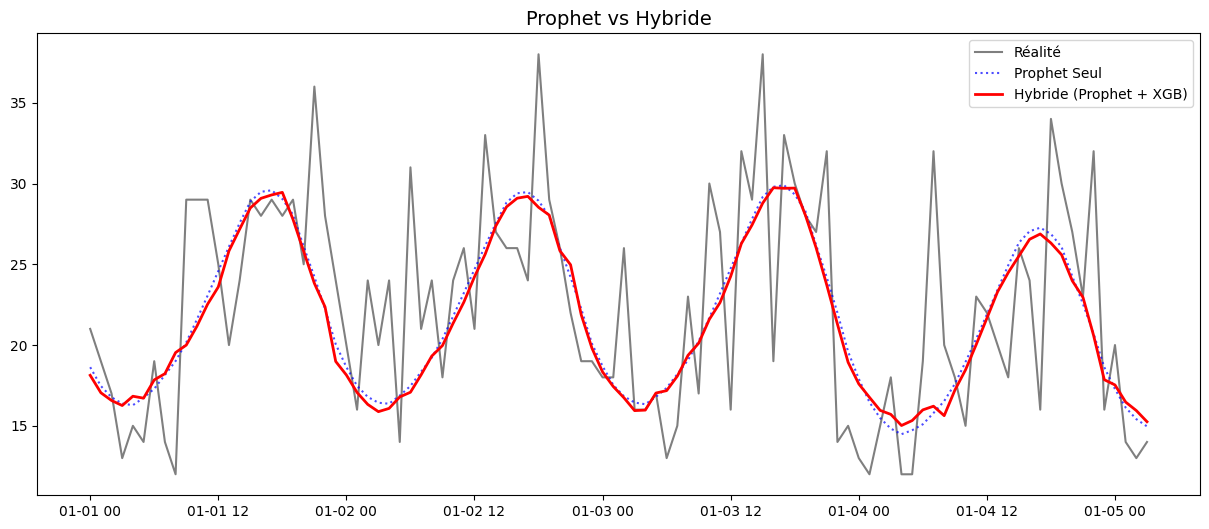

In [17]:
# --- 5. La Fusion (Prediction Finale) ---
# A. Prophet prédit le futur
prophet_pred = forecast_test['yhat'].values

# B. XGBoost prédit de combien Prophet va se tromper
correction_pred = xgb_corrector.predict(test[xgb_features])

# C. Somme des deux
final_pred = prophet_pred + correction_pred
final_pred = np.maximum(final_pred, 0) # Pas de patients négatifs

# --- 6. Verdict ---
mae = mean_absolute_error(test['y'], final_pred)
rmse = np.sqrt(mean_squared_error(test['y'], final_pred))

print(f"\n--- RÉSULTAT Prophet (En solo) ---")
print(f"MAE: {mean_absolute_error(test['y'], prophet_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test['y'], prophet_pred)):.2f}")
print(f"\n--- RÉSULTAT HYBRIDE ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualisation de la correction
plt.figure(figsize=(15, 6))
limit = 100
plt.plot(test['ds'].iloc[:limit], test['y'].iloc[:limit], label='Réalité', color='black', alpha=0.5)
plt.plot(test['ds'].iloc[:limit], prophet_pred[:limit], label='Prophet Seul', color='blue', linestyle=':', alpha=0.7)
plt.plot(test['ds'].iloc[:limit], final_pred[:limit], label='Hybride (Prophet + XGB)', color='red', linewidth=2)
plt.title('Prophet vs Hybride', fontsize=14)
plt.legend()
plt.show()

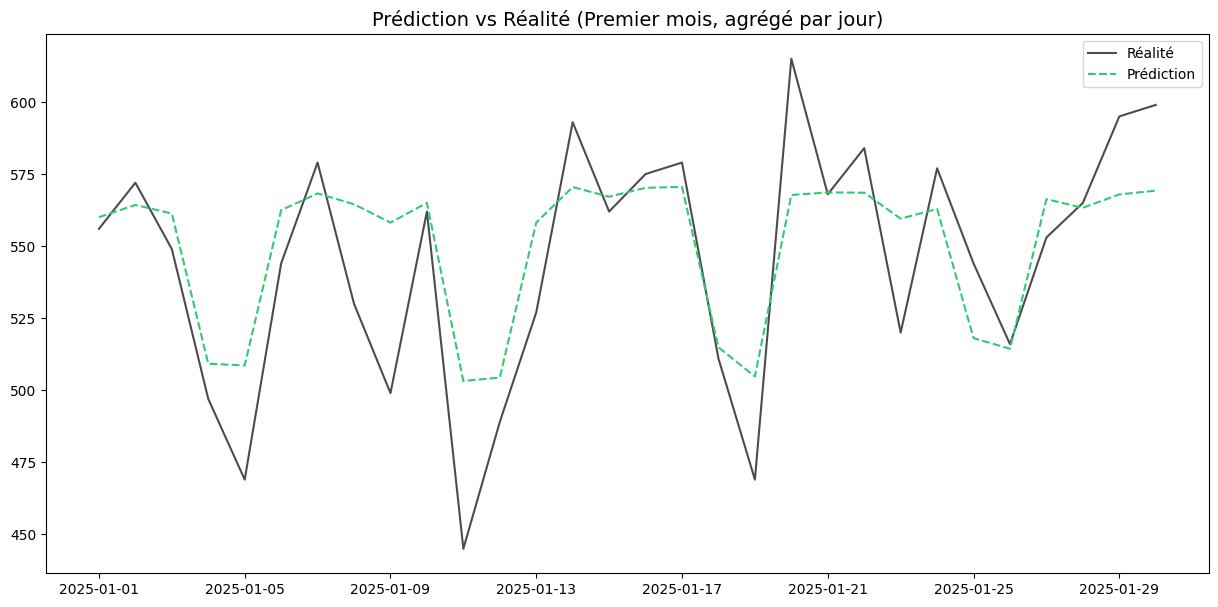

In [18]:
# zoom sur le premier mois, mais on agrège les données par jour
plt.figure(figsize=(15, 7))
test_daily = test.set_index('ds').resample('d').sum().reset_index()
y_true_daily = test_daily['y'].values
y_pred_daily = pd.Series(predictions, index=test['ds']).resample('d').sum().values
plt.plot(test_daily['ds'][:30], y_true_daily[:30], label='Réalité', color='black', alpha=0.7)
plt.plot(test_daily['ds'][:30], y_pred_daily[:30], label='Prédiction', color='#2ECC71', linestyle='--')
plt.title('Prédiction vs Réalité (Premier mois, agrégé par jour)', fontsize=14)
plt.legend()
plt.show()

---
# Partie 2 : Prédiction de l'Occupation des Lits

**Choix méthodologique :** Nous utilisons uniquement **Prophet** pour cette prédiction.

Les tests préliminaires ont montré que :
- XGBoost et le modèle hybride n'apportent pas d'amélioration significative
- L'occupation des lits est une métrique plus lisse (stock vs flux), mieux adaptée à Prophet
- La simplicité d'implémentation de Prophet facilite la maintenance en production

## 2.1 Préparation des données

Les régresseurs utilisés reflètent les facteurs influençant l'occupation :
- **Nombre d'admissions** : Entrées de patients
- **Gravité moyenne** : Patients graves restent plus longtemps
- **Durée de séjour estimée** : Impact direct sur l'occupation
- **Indicateurs contextuels** : Épidémie (plus de patients)

In [19]:
# C'est ici qu'on définit la réalité de l'hôpital entier.
df_global = df.set_index('timestamp_admission').resample('h').agg({
    'Lits_Occupes': 'mean',          # STOCK : On prend la moyenne car la valeur est répétée
    'Nombre_Admissions': 'sum',      # FLUX : On additionne tous les entrants
    'gravite': 'mean',               # INTENSITÉ : Gravité moyenne globale
    'duree_sejour_estimee': 'mean',  # DURÉE : Durée moyenne globale
    'Indicateur_Epidemie': 'max',    # CONTEXTE
    'Indicateur_Greve': 'max'
}).reset_index()

# Préparation pour Prophet
df_prophet_beds = df_global.rename(columns={
    'timestamp_admission': 'ds',
    'Lits_Occupes': 'y' # La cible change ! C'est maintenant les lits.
})

cutoff_date = '2025-01-01'
train_beds = df_prophet_beds[df_prophet_beds['ds'] < cutoff_date]
test_beds = df_prophet_beds[df_prophet_beds['ds'] >= cutoff_date]

## 2.2 Configuration et entraînement de Prophet

**Saisonnalités activées :**
- **Journalière** : Cycle jour/nuit (sorties principalement en journée)
- **Hebdomadaire** : Moins de sorties le week-end
- **Annuelle** : Variations saisonnières de l'occupation

**Régresseurs :** Admissions, gravité, durée de séjour, épidémie

In [20]:
# L'occupation a une saisonnalité différente des admissions.
# Elle est plus lente. Moins de bruit haute fréquence.
m_beds = Prophet(
    daily_seasonality=True,  # Cycle jour/nuit (sorties en journée)
    weekly_seasonality=True, # Cycle semaine (moins de sorties le WE)
    yearly_seasonality=True,
    seasonality_prior_scale=10.0 # On laisse la saisonnalité s'exprimer
)

# Ajout des Régresseurs (Vos inputs)
# Note : Dans la vraie vie, pour 'future', vous utiliseriez les PREDICTIONS d'admissions.
# Ici, on utilise les valeurs réelles pour tester la mécanique.
m_beds.add_regressor('Nombre_Admissions')
m_beds.add_regressor('gravite')
m_beds.add_regressor('duree_sejour_estimee')
m_beds.add_regressor('Indicateur_Epidemie')

print("Entraînement du modèle de Stock (Lits)...")
m_beds.fit(train_beds)


Entraînement du modèle de Stock (Lits)...


10:40:56 - cmdstanpy - INFO - Chain [1] start processing
10:42:00 - cmdstanpy - INFO - Chain [1] done processing


## 2.3 Évaluation du modèle d'occupation

Analyse des performances avec visualisation sur un mois complet.
L'analyse des composants montre l'impact de chaque régresseur sur l'occupation.

--- RÉSULTATS OCCUPATION ---
MAE: 31.47 lits
Moyenne des lits occupés: 1484
Erreur en pourcentage: 2.12%


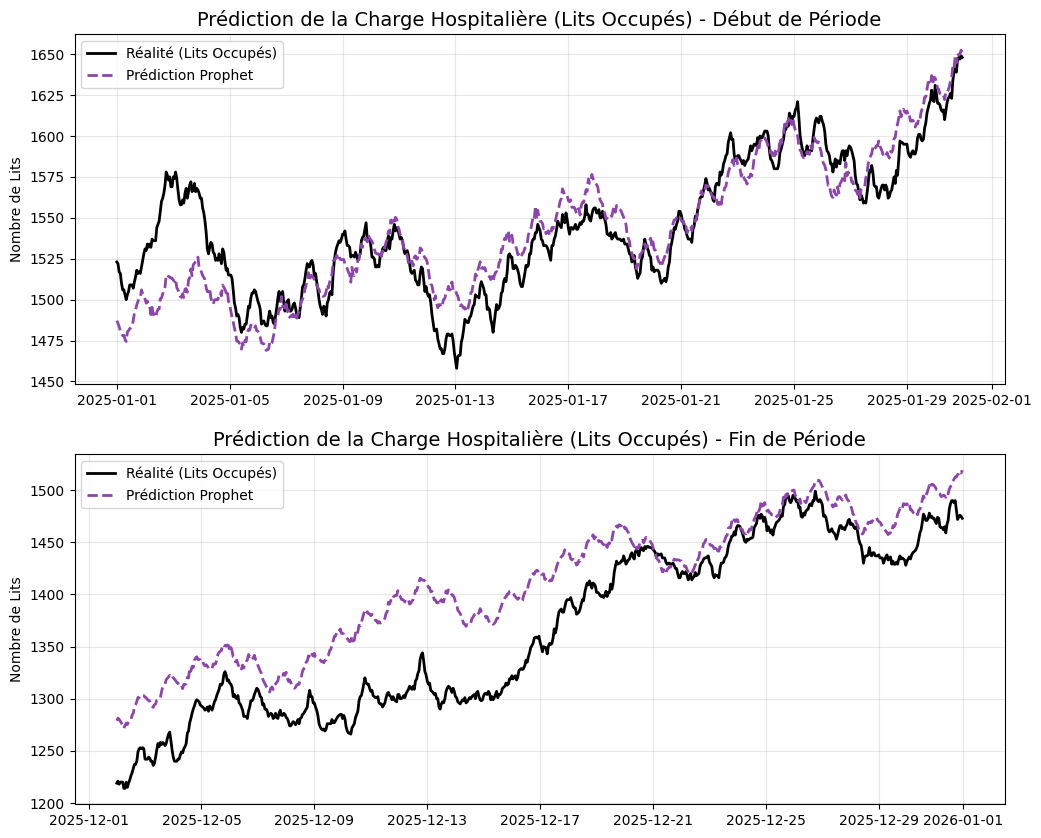

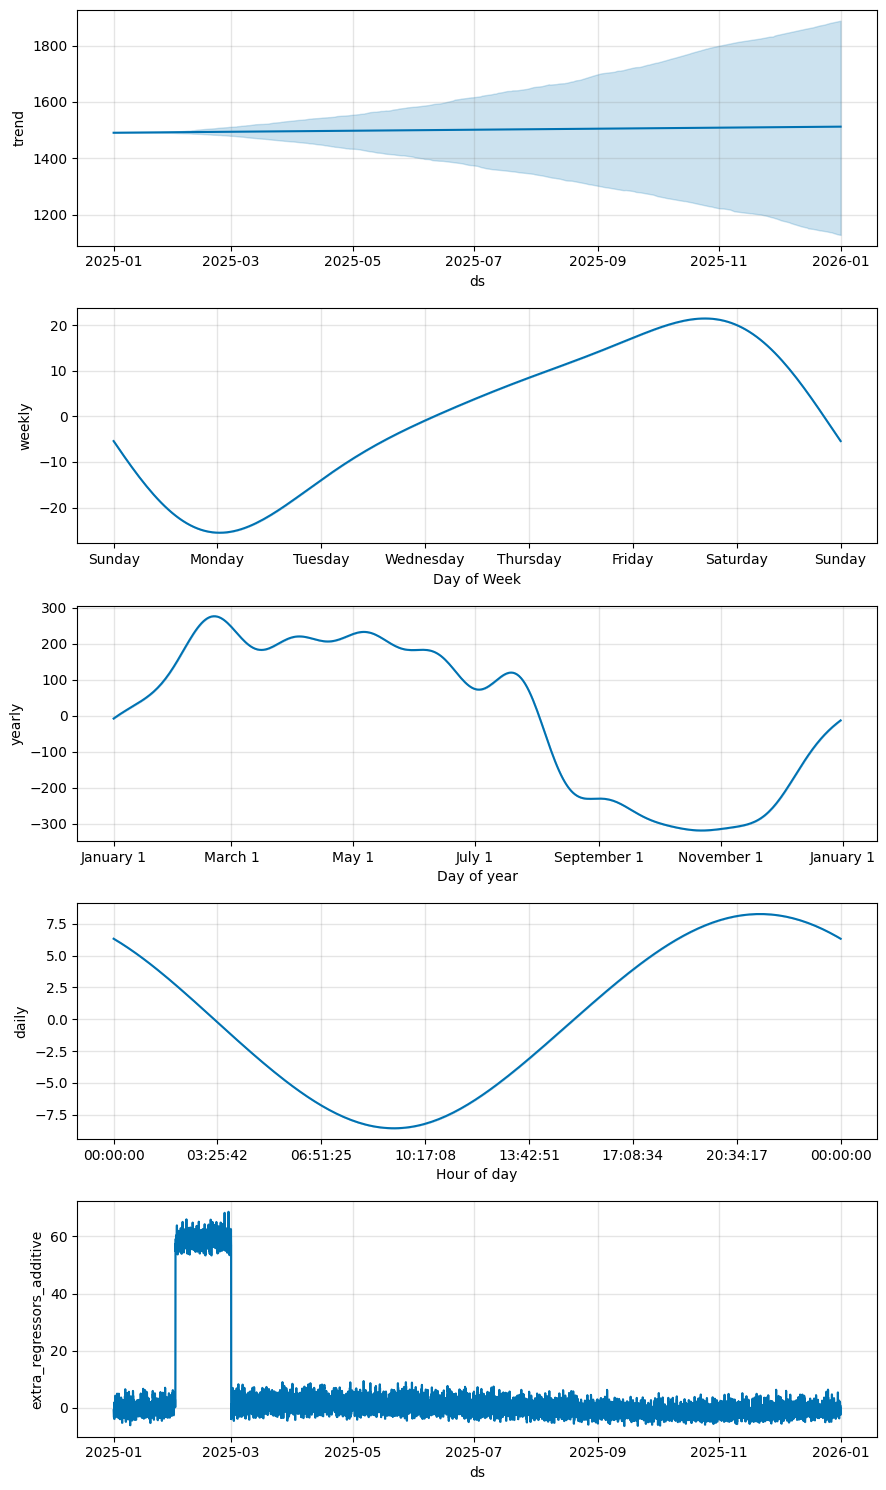

In [21]:
forecast_beds = m_beds.predict(test_beds)

y_true = test_beds['y'].values
y_pred = forecast_beds['yhat'].values
mae = mean_absolute_error(y_true, y_pred)

print(f"--- RÉSULTATS OCCUPATION ---")
print(f"MAE: {mae:.2f} lits")
print(f"Moyenne des lits occupés: {y_true.mean():.0f}")
print(f"Erreur en pourcentage: {(mae / y_true.mean()) * 100:.2f}%")

# Visualisation
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
# Zoom sur 1 mois (environ 700h) au début de la période car l'occupation bouge lentement
limit = 720
axs[0].plot(test_beds['ds'].iloc[:limit], y_true[:limit], label='Réalité (Lits Occupés)', color='black', linewidth=2)
axs[0].plot(test_beds['ds'].iloc[:limit], y_pred[:limit], label='Prédiction Prophet', color='#8E44AD', linestyle='--', linewidth=2) # Violet
axs[0].set_title('Prédiction de la Charge Hospitalière (Lits Occupés) - Début de Période', fontsize=14)
axs[0].set_ylabel('Nombre de Lits')
axs[0].legend()
axs[0].grid(True, alpha=0.3)
# On zoome sur 1 mois (environ 700h) mais à la fin de la période
axs[1].plot(test_beds['ds'].iloc[-limit:], y_true[-limit:], label='Réalité (Lits Occupés)', color='black', linewidth=2)
axs[1].plot(test_beds['ds'].iloc[-limit:], y_pred[-limit:], label='Prédiction Prophet', color='#8E44AD', linestyle='--', linewidth=2) # Violet
axs[1].set_title('Prédiction de la Charge Hospitalière (Lits Occupés) - Fin de Période', fontsize=14)
axs[1].set_ylabel('Nombre de Lits')
axs[1].legend()
axs[1].grid(True, alpha=0.3)
plt.show()

# Composants (Pour voir si les admissions impactent vraiment l'occupation)
fig_comp = m_beds.plot_components(forecast_beds)

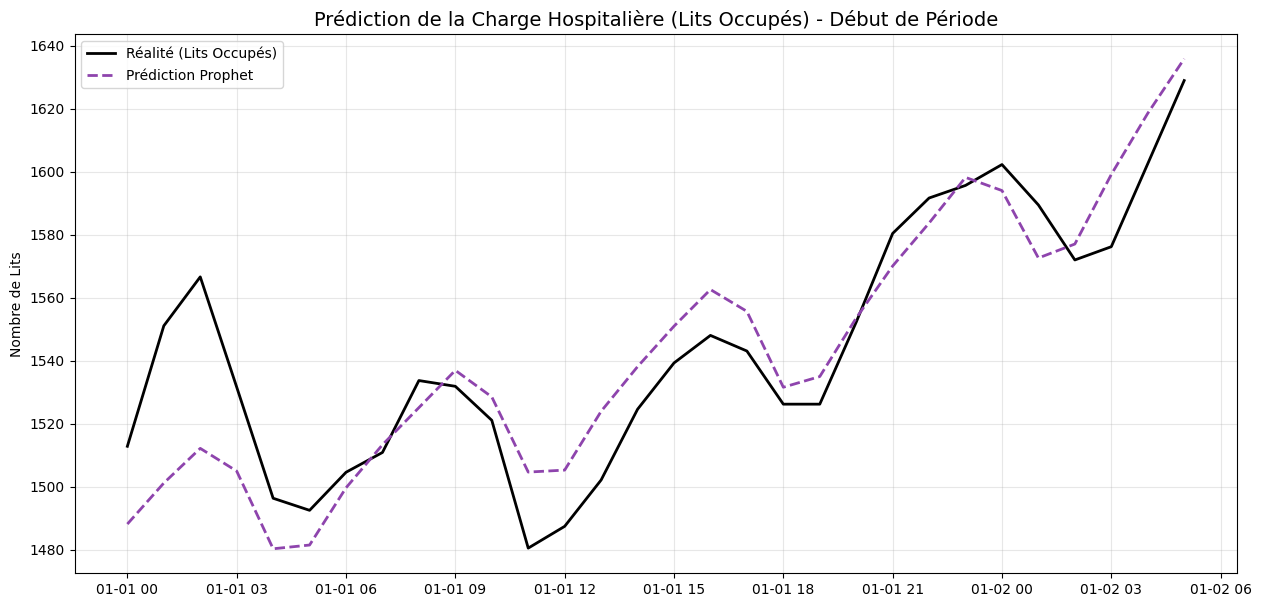

In [22]:
# zoom sur le premier mois, mais on agrège les données par jour
y_true = test_beds.set_index('ds').resample('d').agg({'y': 'mean'}).reset_index()['y'].values
y_pred = forecast_beds.set_index('ds').resample('d').agg({'yhat': 'mean'}).reset_index()['yhat'].values

plt.figure(figsize=(15, 7))
limit = 30
plt.plot(test_beds['ds'].iloc[:limit], y_true[:limit], label='Réalité (Lits Occupés)', color='black', linewidth=2)
plt.plot(test_beds['ds'].iloc[:limit], y_pred[:limit], label='Prédiction Prophet', color='#8E44AD', linestyle='--', linewidth=2) # Violet
plt.title('Prédiction de la Charge Hospitalière (Lits Occupés) - Début de Période', fontsize=14)
plt.ylabel('Nombre de Lits')
plt.legend()
plt.grid(True, alpha=0.3)

## 2.4 Sauvegarde du modèle d'occupation

Modèle exporté pour intégration dans le système de prédiction.

In [23]:
# save the model
joblib.dump(m_beds, 'beds_prophet_model.pkl')

['beds_prophet_model.pkl']

---
# Partie 3 : Prédiction de la Consommation d'EPI

**Choix méthodologique :** Comme pour l'occupation des lits, nous utilisons uniquement **Prophet**.

La consommation d'EPI (Équipements de Protection Individuelle) est directement liée à :
- L'activité hospitalière (nombre de patients, admissions)
- Le personnel présent
- Le contexte sanitaire (épidémie = plus de précautions)

## 3.1 Préparation des données

Agrégation horaire avec les variables explicatives pertinentes :
- **Lits occupés** : Plus de patients = plus de consommation
- **Admissions** : Nouveaux patients nécessitent des EPI frais
- **Personnel présent** : Plus de soignants = plus de consommation
- **Indicateurs contextuels** : Épidémie et grève

In [24]:
# Agrégation
# EPI et Personnel sont des métriques globales -> MEAN
# Admissions sont des flux -> SUM
df_epi = df.set_index('timestamp_admission').resample('h').agg({
    'EPI_Consommation': 'mean',      # La cible
    'Lits_Occupes': 'mean',          # Le stock de patients
    'Nombre_Admissions': 'sum',      # Le flux de nouveaux
    'Personnel_Present': 'mean',     # La main d'oeuvre
    'Indicateur_Epidemie': 'max',    # Le coefficient multiplicateur de risque
    'Indicateur_Greve': 'max'
}).reset_index()

# Renommage pour Prophet
df_prophet_epi = df_epi.rename(columns={
    'timestamp_admission': 'ds',
    'EPI_Consommation': 'y'
})

# Split Temporel
cutoff_date = '2025-01-01'
train_epi = df_prophet_epi[df_prophet_epi['ds'] < cutoff_date]
test_epi = df_prophet_epi[df_prophet_epi['ds'] >= cutoff_date]


## 3.2 Configuration et entraînement de Prophet

**Saisonnalités :**
- **Journalière** : La consommation suit les quarts de travail (3x8h)
- **Hebdomadaire** : Activité réduite le week-end

**Régresseurs :** Occupation, admissions, personnel, épidémie, grève

In [25]:
# Configuration Prophet
# La consommation suit les quarts de travail (3x8h) donc cycle journalier fort.
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    seasonality_prior_scale=10.0 # On laisse la saisonnalité respirer
)

# Ajout des variables explicatives (Régresseurs)
# Note : Pour prédire le futur, vous devrez fournir ces valeurs (estimées) dans le futur.
m.add_regressor('Lits_Occupes')
m.add_regressor('Nombre_Admissions')
m.add_regressor('Personnel_Present')
m.add_regressor('Indicateur_Epidemie')
m.add_regressor('Indicateur_Greve')

# Entraînement
print("Initialisation du module logistique...")
m.fit(train_epi)


Initialisation du module logistique...


10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:20 - cmdstanpy - INFO - Chain [1] done processing


## 3.3 Évaluation du modèle EPI

Analyse des performances et visualisation des composants pour comprendre les facteurs d'influence.

--- RÉSULTAT EPI ---
MAE: 1.78
Erreur Relative: 0.39%


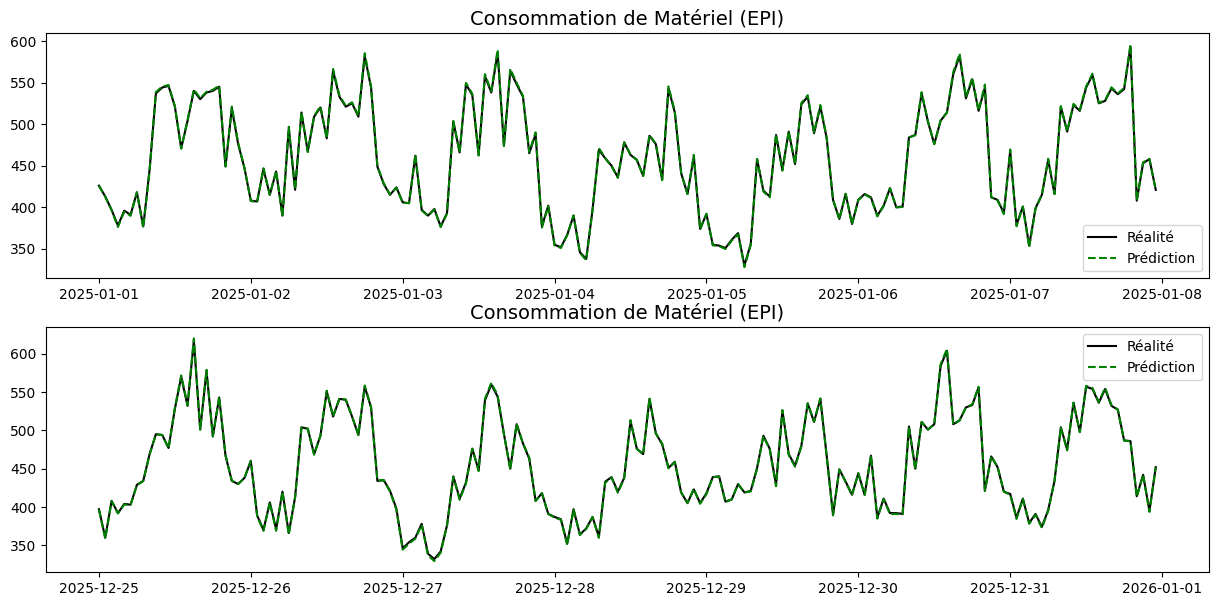

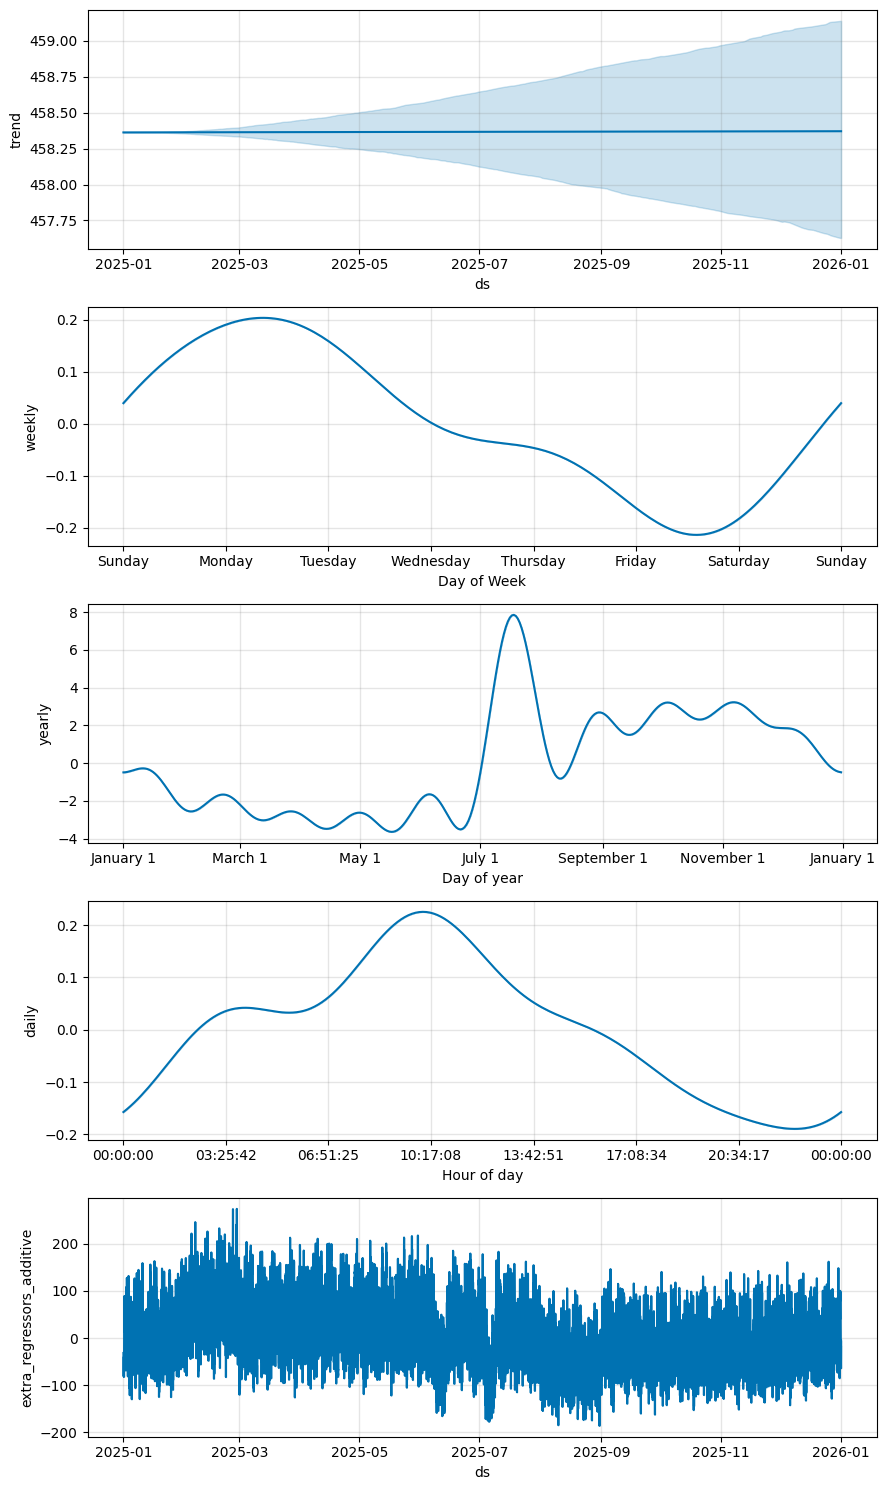

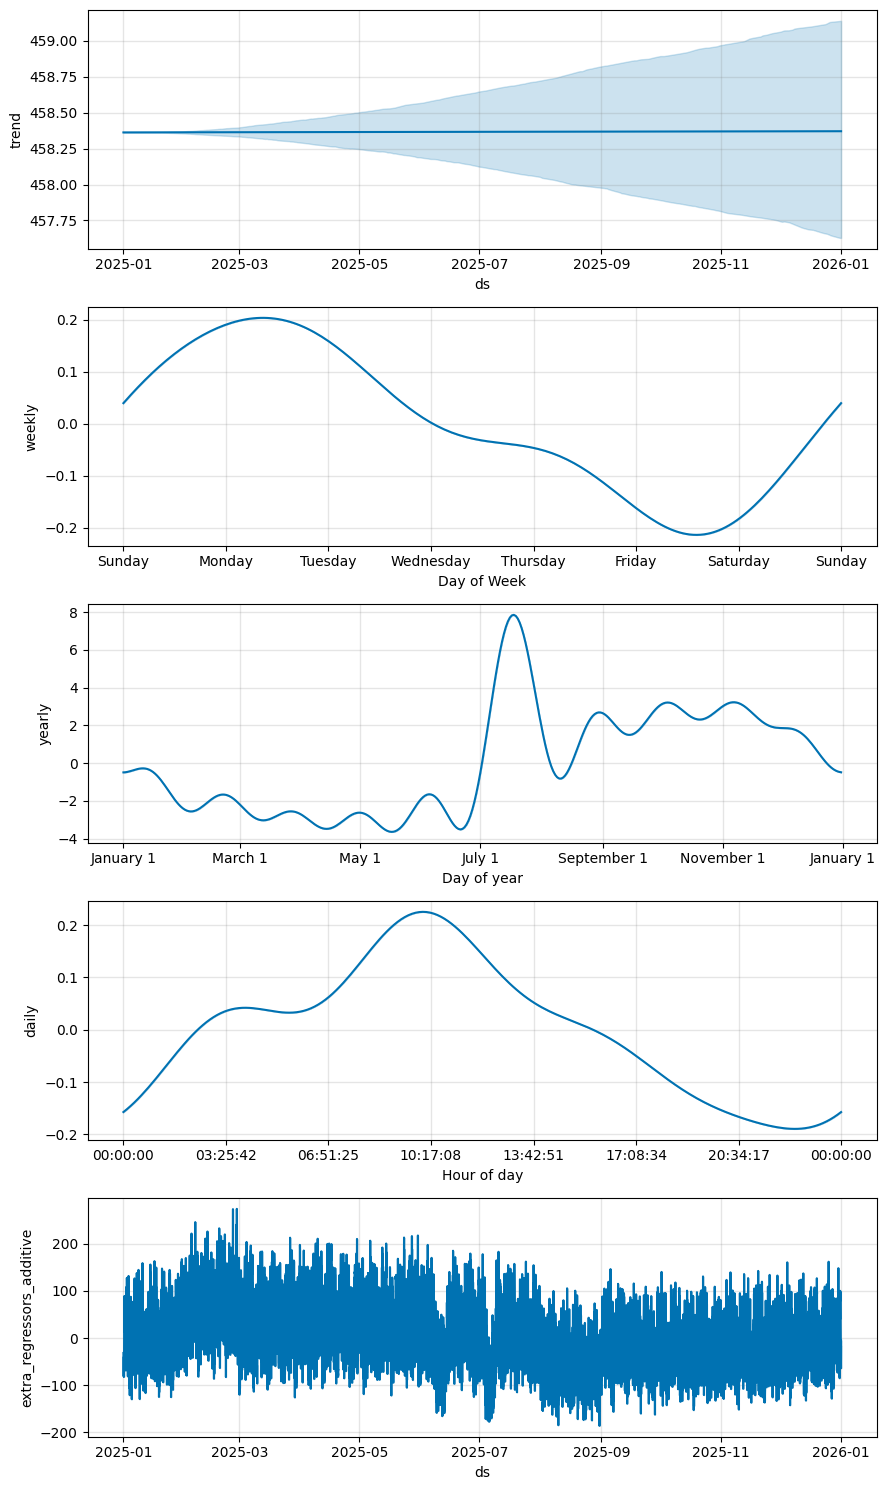

In [26]:
# Prédiction
forecast = m.predict(test_epi)

# Évaluation
y_true = test_epi['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)

print(f"--- RÉSULTAT EPI ---")
print(f"MAE: {mae:.2f}")
print(f"Erreur Relative: {(mae / y_true.mean()) * 100:.2f}%")

# Visualisation
fig, axs = plt.subplots(2, 1, figsize=(15, 7))
limit = 168 # Une semaine
# début
axs[0].plot(test_epi['ds'].iloc[:limit], y_true[:limit], label='Réalité', color='black')
axs[0].plot(test_epi['ds'].iloc[:limit], y_pred[:limit], label='Prédiction', color='green', linestyle='--')
axs[0].set_title('Consommation de Matériel (EPI)', fontsize=14)
axs[0].legend()
# fin
axs[1].plot(test_epi['ds'].iloc[-limit:], y_true[-limit:], label='Réalité', color='black')
axs[1].plot(test_epi['ds'].iloc[-limit:], y_pred[-limit:], label='Prédiction', color='green', linestyle='--')
axs[1].set_title('Consommation de Matériel (EPI)', fontsize=14)
axs[1].legend()
plt.show()

# L'Analyse des composants est vitale ici
m.plot_components(forecast)

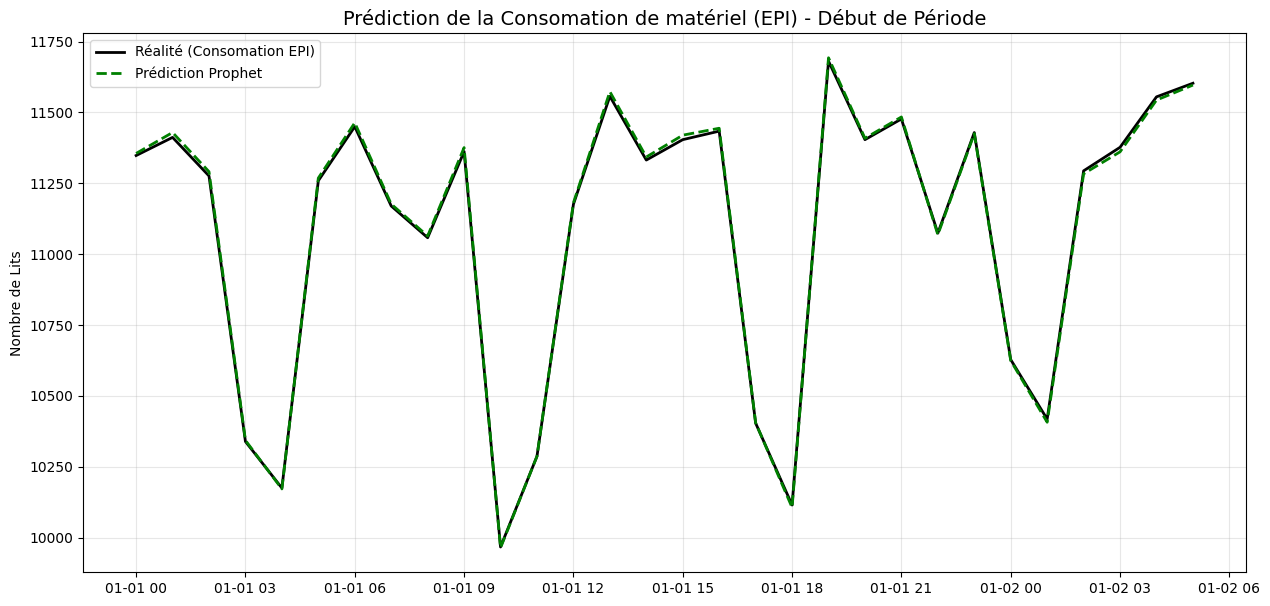

In [29]:
# zoom sur le premier mois, mais on agrège les données par jour

y_true = test_epi.set_index('ds').resample('d').agg({'y': 'sum'}).reset_index()['y'].values
y_pred = forecast.set_index('ds').resample('d').agg({'yhat': 'sum'}).reset_index()['yhat'].values

plt.figure(figsize=(15, 7))
limit = 30
plt.plot(test_beds['ds'].iloc[:limit], y_true[:limit], label='Réalité (Consomation EPI)', color='black', linewidth=2)
plt.plot(test_beds['ds'].iloc[:limit], y_pred[:limit], label='Prédiction Prophet', color='green', linestyle='--', linewidth=2) # Violet
plt.title('Prédiction de la Consomation de matériel (EPI) - Début de Période', fontsize=14)
plt.ylabel('Nombre de Lits')
plt.legend()
plt.grid(True, alpha=0.3)

## 3.4 Sauvegarde du modèle EPI

Export du modèle pour une utilisation en production.



In [28]:
# save the model
joblib.dump(m, 'epi_prophet_model.pkl')

['epi_prophet_model.pkl']

---
# Conclusion

Ce notebook a permis de développer trois modèles de prédiction :

| Métrique | Modèle choisi | Justification |
|----------|---------------|---------------|
| **Admissions** | Hybride (Prophet + XGBoost) | Meilleure précision sur les pics |
| **Lits occupés** | Prophet seul | Métrique lisse, peu de gain avec XGBoost |
| **Consommation EPI** | Prophet seul | Simplicité et performances suffisantes |

Les modèles sont sauvegardés au format `.pkl` pour intégration dans l'application SmartCare Analytics.